In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


# Imports


In [7]:
# Standard Library Imports
import datetime
import json
import os
import sys
import time
from itertools import product

import matplotlib.pyplot as plt
import networkx as nx

# Third-Party Library Imports
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import seaborn as sns
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Access environment variables
python_path = os.getenv('PYTHONPATH')
data_dir = os.getenv('DATA_DIR')
src_dir = os.getenv('SRC_DIR')
output_dir = os.getenv('OUTPUT_DIR')

from src.visualization.edgebundling.addZCoordinate import ZCoordinateAdder
from src.visualization.edgebundling.frLayoutUtility import frLayoutUtility
from src.visualization.edgebundling.graphReadingUtility import graphReadingUtility
from src.visualization.edgebundling.graphToDfUtility import GraphProcessingUtility
from src.visualization.edgebundling.hammerBundling3D import hammer_bundle
from src.visualization.edgebundling.nodesEdgesJsonSaver import edgesSaver, nodesSaver
from src.visualization.edgebundling.postBundlingUtility import postBundlingUtility
from src.visualization.edgebundling.pruneEdges import pruneEdges

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None

# Set Seaborn Style
sns.set_style("white")


# Define Paths


In [13]:
subgraph = False

# 2. Constants and configuration
INPUT_GRAPH_PATH = data_dir + "/08-analysis-data/2025/graph_analysis.graphml"
CLUSTER_TREE_PATH = output_dir + "/cluster-qualifications_2025/cluster-label-tree/cluster_tree_filtered.json"
OUTPUT_DIR = data_dir + "/09-threeJs/"
FR_GRAPH_FILENAME = f"FR_Layout_Graph_{datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}.graphml"
# external env
THREEJS_OUTPUT_DIR = os.getenv('THREEJS_OUTPUT_DIR')
NODES_DATA_FILENAME = f"nodes_{datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}scale2.json"
EDGES_DATA_FILENAME = f"edges_{datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}scale2.json"

if subgraph:
    FR_GRAPH_FILENAME = f"SUBG_FR_Layout_Graph_{datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}.graphml"
    NODES_DATA_FILENAME = f"SUBG_nodes_{datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}.json"
    EDGES_DATA_FILENAME = f"SUBG_edges_{datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}.json"


## read and layout the graph


In [4]:
g = graphReadingUtility.read_and_clean_graph(INPUT_GRAPH_PATH)
total_nodes = len(g.vs)
print(f"Total nodes in the graph: {total_nodes}")


if subgraph:

    cluster_list = list(range(30, 40))

    # subset to only cluster 0 to 100
    g = graphReadingUtility.subgraph_of_clusters(g, cluster_list)

    total_nodes = len(g.vs)
    print(f"Total nodes in the sub graph: {total_nodes}")
print("#" * 100)

################################################################################################
layout_params = {
    # "k": 0.5, # distance between nodes; best to leave it to algo
    "iterations": 50,  # (default=50) use 100
    "threshold": 0.0001,  # default 0.0001
    "weight": "weight",
    "scale": 10000,
    "center": (0, 0),
    "dim": 2,
    "seed": 1887,
}

g_fr, pos = frLayoutUtility.fr_layout_nx(g, layout_params)


print("#" * 100)


################################################################################################

# Add z-coordinate to nodes based on centrality
z_adder = ZCoordinateAdder(g_fr, percentage=20)
g_z = z_adder.add_z_coordinate_to_nodes()

print("#" * 100)


NameError: name 'graphReadingUtility' is not defined

## save graph with x, y, z coordinates


In [5]:
# Assuming g_z is your NetworkX graph object
full_path = OUTPUT_DIR + FR_GRAPH_FILENAME

# Save as GraphML file
nx.write_graphml(g_z, full_path)
print(f"Graph saved as GraphML: {full_path}")

# read back in
# full_path = OUTPUT_DIR +'FR_Layout_Graph_2025-04-16-21-30-09.graphml'
# g_z = nx.read_graphml(full_path)


Graph saved as GraphML: /Users/jlq293/Projects/Study-1-Bibliometrics/data/09-threeJs/FR_Layout_Graph_2025-04-22-15-55-44.graphml


In [6]:
list(g_z.nodes(data=True))[0]


(0,
 {'title': 'Kinetics of citalopram in man; plasma levels in patients',
  'year': 1982,
  'cluster': 19,
  'node_index': 0,
  'node_name': '0',
  'centrality': 0.151957843626865,
  '_igraph_index': 0,
  'x': np.float64(-589.8026123046875),
  'y': np.float64(1040.77685546875),
  'z': np.float64(580.4662581995266)})

## Prune


In [7]:
################################################################################################
# Prune edges by weight percentile
percentile_to_keep = 0.15  # we keep 15 %
pruner = pruneEdges(
    g_z,
)
print("Pruning edges by weight percentile:")
g_pruned_weight = pruner.prune_edges_by_weight_percentile(percentile_to_keep)
summary = pruner.get_prune_summary()
print("Summary after pruning by weight:")
print(summary)

print("\n" + "#" * 80 + "\n")

# Prune random percentage of edges
percentile_to_keep = 0.15  # we keep 15 %
pruner = pruneEdges(
    g_z,
)
print("Pruning edges randomly:")
g_pruned_random = pruner.prune_edges_randomly(percentile_to_keep)
summary = pruner.get_prune_summary()
print("Summary after random pruning:")
print(summary)

print("#" * 80)


Pruning edges by weight percentile:
Weight Threshold: 0.66
Edges with this weight: 0
Kept top 15.0% of edges by weight
Edges kept: 82684 out of 551227
Summary after pruning by weight:
{'initial_edge_count': 551227, 'final_edge_count': 82684, 'initial_isolates': 0, 'final_isolates': 6595}

################################################################################

Pruning edges randomly:
Kept 15.0% of edges randomly
Edges kept: 82684 out of 551227
Summary after random pruning:
{'initial_edge_count': 551227, 'final_edge_count': 82684, 'initial_isolates': 0, 'final_isolates': 2026}
################################################################################


## Dataframe conversion


In [8]:
g_pruned_random.vs[0]


igraph.Vertex(<igraph.Graph object at 0x10abb7e50>, 0, {'_nx_name': 0, 'title': 'Kinetics of citalopram in man; plasma levels in patients', 'year': 1982, 'cluster': 19, 'node_index': 0, 'node_name': '0', 'centrality': 0.151957843626865, 'x': np.float64(-589.8026123046875), 'y': np.float64(1040.77685546875), 'z': np.float64(580.4662581995266)})

In [9]:
# Convert nodes and edges to DataFrames
nodes_df = GraphProcessingUtility.nodes_to_dataframe(
    g_pruned_random,
    normalize_coordinates=False,
    drop_columns=["node_id", "node_name", "_nx_name"],
)
edges_df = GraphProcessingUtility.edges_to_dataframe(g_pruned_random)

# Add coordinates to edges
edges_with_coords = GraphProcessingUtility.create_edge_df_with_source_target_coords(
    edges_df, nodes_df
)

# Add segment lengths
edges_with_coords_with_length = GraphProcessingUtility.add_segment_length_to_edge_df(
    edges_with_coords
)

# Display the result
edges_with_coords_with_length.head(3)


Segment length statistics:
Min: 0.00
Max: 9378.74
Mean: 2003.80
Median: 1778.42


,edge_id,weight,source,target,source_x,source_y,source_z,target_x,target_y,target_z,segment_length
0,0,0.955605,0,33,-589.802612,1040.776855,580.466258,-649.040833,-336.790009,228.666931,1423.011735
1,1,0.300000,0,35,-589.802612,1040.776855,580.466258,-1863.332764,570.029846,236.956329,1400.528780
2,5,0.300000,0,68,-589.802612,1040.776855,580.466258,155.815750,2225.178223,322.764857,1423.082342


## Check Segment Length Distribution


Number of edges selected: 62013


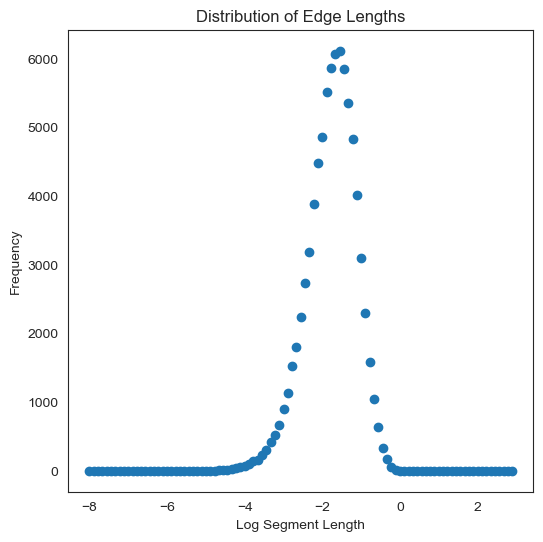

Number of edges selected: 20671


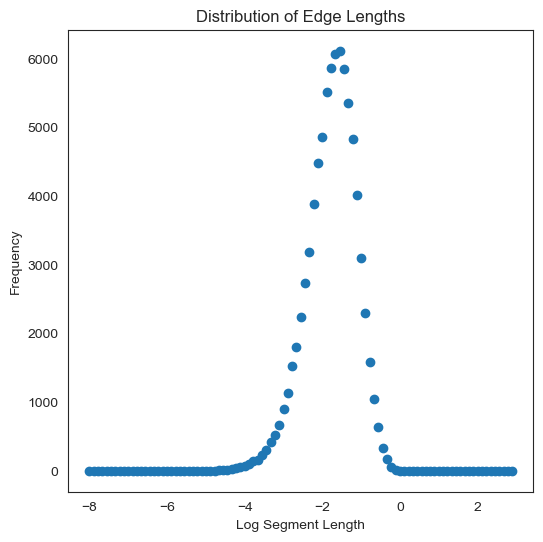

In [10]:
class SegmentLengthDistribution:
    def __init__(self, nodes_df, edges_with_coords_with_length):
        """
        Initializes the GraphProcessor with the node and edge dataframes.

        Args:
            nodes_df (pd.DataFrame): DataFrame containing node information.
            edges_with_coords_with_length (pd.DataFrame): DataFrame containing edge data including coordinates and lengths.
        """
        self.nodes_df = nodes_df
        self.edges_df = edges_with_coords_with_length.copy()
        self.normalized_edge_df = self.edges_df.copy()

    def normalize_edges(self):
        """
        Normalize the coordinates and segment lengths in the edge dataframe.
        """
        to_normalize = [
            "source_x",
            "source_y",
            "source_z",
            "target_x",
            "target_y",
            "target_z",
            "segment_length",
        ]

        # Reset the node indices in edges_df to match those in nodes_df
        index_mapping = {
            old_index: new_index
            for new_index, old_index in enumerate(self.nodes_df["node_index"].unique())
        }

        # Map the source and target indices in the edges DataFrame
        self.normalized_edge_df["source"] = self.normalized_edge_df["source"].map(
            index_mapping
        )
        self.normalized_edge_df["target"] = self.normalized_edge_df["target"].map(
            index_mapping
        )

        # Normalize the relevant columns
        for col in to_normalize:
            self.normalized_edge_df[col] = GraphProcessingUtility.minmax_normalize(
                self.normalized_edge_df[col]
            )

    def create_adjacency_matrix(self, percentile=50):
        """
        Create an adjacency matrix for the graph using the normalized edges.

        Args:
            percentile (float): The percentile threshold to use for selecting edges based on segment length.
                                Default is the 50th percentile (median).

        Returns:
            mat (sparse.coo_matrix): Sparse matrix representing the adjacency matrix.
        """
        Nnodes = self.nodes_df.shape[0]

        # Calculate the length threshold based on the specified percentile
        length_threshold = np.percentile(
            self.normalized_edge_df["segment_length"], percentile
        )

        # Select edges whose length is above the specified percentile threshold
        subedges = self.normalized_edge_df["segment_length"] > length_threshold

        print(f"Number of edges selected: {subedges.sum()}")

        # Construct the adjacency matrix
        mat = sparse.coo_matrix(
            (
                np.ones(self.normalized_edge_df.loc[subedges].shape[0], dtype=int),
                (
                    self.normalized_edge_df.loc[subedges, "source"].values,
                    self.normalized_edge_df.loc[subedges, "target"].values,
                ),
            ),
            shape=(Nnodes, Nnodes),
        )

        return mat

    def find_connected_components(self, mat):
        """
        Find connected components in the graph represented by the adjacency matrix.

        Args:
            mat (sparse.coo_matrix): The adjacency matrix of the graph.

        Returns:
            tuple: A tuple containing the number of components and membership information for nodes.
        """
        ncomp, membership = sparse.csgraph.connected_components(mat)
        return ncomp, membership

    def plot_edge_length_distribution(self):
        """
        Visualize the distribution of edge lengths using a histogram. This helps us understand the distribution of
        segment lengths in the graph.
        """
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))

        # Histogram of segment lengths (log-binned)
        dist, bins = np.histogram(
            self.normalized_edge_df["segment_length"].values,
            bins=np.exp(np.linspace(-8, 3, 100)),
        )

        # Scatter plot of the log-transformed bins against the distribution
        ax.scatter(np.log(bins[:-1]), dist)

        # Add labels
        ax.set_xlabel("Log Segment Length")
        ax.set_ylabel("Frequency")
        ax.set_title("Distribution of Edge Lengths")

        plt.show()


# Example usage
graph_processor = SegmentLengthDistribution(nodes_df, edges_with_coords_with_length)
graph_processor.normalize_edges()
adjacency_matrix = graph_processor.create_adjacency_matrix(
    percentile=25
)  # Using 75th percentile instead of median
n_components, membership = graph_processor.find_connected_components(adjacency_matrix)
graph_processor.plot_edge_length_distribution()

adjacency_matrix = graph_processor.create_adjacency_matrix(
    percentile=75
)  # Using 75th percentile instead of median
n_components, membership = graph_processor.find_connected_components(adjacency_matrix)
graph_processor.plot_edge_length_distribution()


# BUNDLE


In [11]:
# get dictionary of segment length, 25th, 50th, 75th percentile
segment_length_dict = {
    "10th_percentile": edges_with_coords_with_length["segment_length"].quantile(0.10),
    "20th_percentile": edges_with_coords_with_length["segment_length"].quantile(0.20),
    "25th_percentile": edges_with_coords_with_length["segment_length"].quantile(0.25),
    "50th_percentile": edges_with_coords_with_length["segment_length"].median(),
    "75th_percentile": edges_with_coords_with_length["segment_length"].quantile(0.75),
}
segment_length_dict


{'10th_percentile': np.float64(726.9869235330782),
 '20th_percentile': np.float64(1017.4231841505389),
 '25th_percentile': np.float64(1143.9343209145788),
 '50th_percentile': 1778.422036459005,
 '75th_percentile': np.float64(2620.0134889029305)}

## Set Threshold for Edge Length


In [12]:
# get edges to bundle above a certain threshold
# threshold = 0.03
threshold = segment_length_dict["20th_percentile"]
edges_to_bundle = edges_with_coords_with_length["segment_length"] > threshold
edges_to_bundle_df = edges_with_coords_with_length.loc[edges_to_bundle].reset_index(
    drop=True
)
print(f"Total Nr of Pruned Edges: {len(edges_with_coords_with_length)}")
print(f"Edges to Bundle: {edges_to_bundle.sum()}")
print(
    f"Edges without bundling: {len(edges_with_coords_with_length)- edges_to_bundle.sum()}"
)


Total Nr of Pruned Edges: 82684
Edges to Bundle: 66147
Edges without bundling: 16537


## Bundling


In [13]:
bundled_edge_pts = hammer_bundle(
    nodes_df[["x", "y", "z"]],
    edges_to_bundle_df[["source", "target"]],
    initial_bandwidth=0.05,
    decay=0.7,
    tension=0.3,
    accuracy=5 * 10**2,
    weight=None,
    advect_iterations=50,
    iterations=5,
    min_segment_length=0.01,
    max_segment_length=0.05,
)
bundled_edge_pts.head()


Process Bundling
Start Bundling
Start Smoothing


,x,y,z
0,-589.802612,1040.776855,580.466258
1,-703.906241,964.551415,544.295233
2,-809.836704,877.257546,503.261958
3,-901.664408,775.448151,456.237919
4,-976.467374,661.425314,404.716704


## Post Bundling Processing

add source and target columns, create clean df and save it


In [14]:
# Example of how to use the class
edge_processor = postBundlingUtility(
    bundled_edge_pts, edges_to_bundle_df, edges_with_coords_with_length, threshold
)
final_edges_df = edge_processor.post_process_edges()


Number of bundled edges: 66147
Number of total edges: 82684
Number of straight edges: 16537


# SAVER


In [15]:
e_saver = edgesSaver(final_edges_df, nodes_df)


In [16]:
e_saver = edgesSaver(final_edges_df, nodes_df)
edges_df_with_color = e_saver.add_color_attr()
edges_df_with_color_year = e_saver.add_year_attr()
edges_df_with_color_year_id = e_saver.add_id_attr()


edges_list = e_saver.transform_edges(
    extra_edge_attributes=["source", "target", "color", "year", "id"]
)

print("Example of an edge:")
print(edges_list[0])

# Save to JSON
e_saver.save_edges_to_json(edges_list, OUTPUT_DIR +  "smaller_" +EDGES_DATA_FILENAME)
e_saver.save_edges_to_json(
    edges_list,
    THREEJS_OUTPUT_DIR + "smaller_" + EDGES_DATA_FILENAME,
)


Color attribute added to edges. 
-1 if inter-clusters, cluster number if intra-cluster edge.
Year attribute added to edges. Using the more recent year if different.
ID attribute added to edges.
Example of an edge:
{'source': 0, 'target': 33, 'color': 19, 'year': 1982, 'id': '0_33', 'points': [{'x': -589.8026123047, 'y': 1040.7768554687, 'z': 580.4662581995}, {'x': -703.9062411815, 'y': 964.5514146525, 'z': 544.2952329469}, {'x': -809.8367039717, 'y': 877.2575455031, 'z': 503.2619577453}, {'x': -901.664407849, 'y': 775.4481512998, 'z': 456.2379187513}, {'x': -976.4673735558, 'y': 661.4253142241, 'z': 404.7167040979}, {'x': -1036.3031172085, 'y': 540.0580233357, 'z': 350.9592445193}, {'x': -1088.2131556498, 'y': 415.7862793515, 'z': 296.5090511945}, {'x': -649.0408325195, 'y': -336.7900085449, 'z': 228.666930791}]}
Edges data saved to /Users/jlq293/Projects/Study-1-Bibliometrics/data/09-threeJs/smaller_edges_2025-04-22-15-55-44scale2.json
Edges data saved to /Users/jlq293/Projects/Random

In [17]:
# save final edges df to csv for easy  access and safety

edges_df_with_color_year_id.to_csv(
    OUTPUT_DIR + "smaller_" + "final_bundled_edges_df.csv", index=False
)


# save nodes


In [18]:
# save nodes
OUTPUT_DIRA = OUTPUT_DIR + NODES_DATA_FILENAME

OUTPUT_DIRB = THREEJS_OUTPUT_DIR + NODES_DATA_FILENAME

n_saver = nodesSaver()
nodes_json = n_saver.save_dataframe_nodes_to_json(
    nodes_df,
    paths=[OUTPUT_DIRA, OUTPUT_DIRB],
    return_json=True,
    attributes=[
        "node_index",
        "year",
        "title",
        "cluster",
        # "doi",
        "centrality",
        "x",
        "y",
        "z",
    ],
)

print("Example of a node:")
nodes_json[0]


Graph nodes saved to /Users/jlq293/Projects/Study-1-Bibliometrics/data/09-threeJs/nodes_2025-04-22-15-55-44scale2.json
Graph nodes saved to /Users/jlq293/Projects/Random Projects/LW-ThreeJS/2d_ssrinetworkviz/src/data/nodes_2025-04-22-15-55-44scale2.json
Example of a node:


{'node_index': 0,
 'year': 1982,
 'title': 'Kinetics of citalopram in man; plasma levels in patients',
 'cluster': 19,
 'centrality': 0.151957843626865,
 'x': -589.8026123046875,
 'y': 1040.77685546875,
 'z': 580.4662581995266}

# Parameter Determination


In [19]:
def explore_hammer_bundle_params(
    edges_df, nodes_df, params, num_runs=5, base_output_dir="output"
):
    """
    Explore different parameter combinations for the hammer_bundle algorithm,
    post-process results, and save outputs.

    Args:
    edges_df (pd.DataFrame): DataFrame containing edge information.
    nodes_df (pd.DataFrame): DataFrame containing node information.
    params (dict): Dictionary of parameter ranges to explore.
    num_runs (int): Number of parameter combinations to try.
    base_output_dir (str): Base directory for saving outputs.

    Returns:
    list: List of dictionaries containing results and file paths for each run.
    """
    global_start_time = time.time()

    all_combinations = list(
        product(
            params["min_edge_length_percentiles"],
            params["initial_bandwidth_values"],
            params["decay_values"],
            params["tension_values"],
            params["min_segment_length_values"],
        )
    )

    print(f"Nr of all possible combinations:", len(all_combinations))

    selected_combinations = np.random.choice(
        len(all_combinations), num_runs, replace=False
    )

    print(f"Selected Combinations:")
    for run in selected_combinations:
        print(all_combinations[run])

    results = []

    for i, combo_index in enumerate(selected_combinations):
        combo = all_combinations[combo_index]
        (
            min_edge_length_percentile,
            initial_bandwidth,
            decay,
            tension,
            min_segment_length,
        ) = combo

        print(f"\nRun {i+1}/{num_runs}")
        print(
            f"Parameters: \n min_edge_length_percentile={min_edge_length_percentile}\n initial_bandwidth={initial_bandwidth}\n decay={decay}\n tension={tension}\n min_segment_length={min_segment_length}"
        )

        # Create a unique identifier for this run
        run_id = f"run_{i+1}_perc{min_edge_length_percentile}_bw{initial_bandwidth}_d{decay}_t{tension}_msl{min_segment_length}"

        # Create output directory for this run
        run_output_dir = os.path.join(base_output_dir, run_id)
        os.makedirs(run_output_dir, exist_ok=True)

        # Calculate threshold and prepare edges for bundling
        threshold = np.percentile(
            edges_df["segment_length"], min_edge_length_percentile
        )
        edges_to_bundle = edges_df["segment_length"] > threshold
        edges_to_bundle_df = edges_df.loc[edges_to_bundle].reset_index(drop=True)

        print(f"Total Nr of Pruned Edges: {len(edges_df)}")
        print(f"Edges to Bundle: {edges_to_bundle.sum()}")

        start_time = time.time()

        try:
            # Run hammer_bundle
            bundled_edge_pts = hammer_bundle(
                nodes_df[["x", "y", "z"]],
                edges_to_bundle_df[["source", "target"]],
                initial_bandwidth=initial_bandwidth,
                decay=decay,
                tension=tension,
                accuracy=5 * 10**2,
                weight=None,
                advect_iterations=50,
                iterations=5,
                min_segment_length=min_segment_length,
                max_segment_length=0.05,
            )

            # Post-processing
            edge_processor = postBundlingUtility(
                bundled_edge_pts, edges_to_bundle_df, edges_df, threshold
            )
            final_edges_df = edge_processor.post_process_edges()

            edge_saver = edgesSaver(final_edges_df, nodes_df)
            edges_df_with_color = edge_saver.add_color_attr()
            edges_list = edge_saver.transform_edges(
                extra_edge_attributes=["source", "target", "color"]
            )
            # Save edges to JSON
            edges_filename = f"edges_{run_id}.json"
            edge_saver.save_edges_to_json(
                edges_list, os.path.join(run_output_dir, edges_filename)
            )
            # Save nodes to JSON
            nodes_filename = f"nodes_{run_id}.json"
            nodes_saver = nodesSaver()
            nodes_json = nodes_saver.save_dataframe_nodes_to_json(
                nodes_df,
                paths=[os.path.join(run_output_dir, nodes_filename)],
                return_json=True,
                attributes=[
                    "doi",
                    "year",
                    "title",
                    "cluster",
                    "centrality",
                    "x",
                    "y",
                    "z",
                    "node_index",
                ],
            )
            end_time = time.time()
            runtime = end_time - start_time
            results.append(
                {
                    "RUN": i + 1,
                    "run_id": run_id,
                    "parameters": {
                        "min_edge_length_percentile": min_edge_length_percentile,
                        "initial_bandwidth": initial_bandwidth,
                        "decay": decay,
                        "tension": tension,
                        "min_segment_length": min_segment_length,
                    },
                    "edges_bundled": int(edges_to_bundle.sum()),
                    "runtime": runtime,
                    "output_dir": run_output_dir,
                }
            )

            print(f"Run completed in {runtime:.2f} seconds")
            # print(f"Results saved in {run_output_dir}")

        except Exception as e:
            print(f"Error in run: {str(e)}")

    print(f"\nTotal time taken: {time.time() - global_start_time:.2f} seconds")
    results.append({"total_runtime": str(time.time() - global_start_time)})

    # Save summary of all runs
    summary_file = os.path.join(base_output_dir, "exploration_summary.json")
    with open(summary_file, "w") as f:
        json.dump(results, f, indent=2)

    return results


In [20]:
# Assuming edges_df and nodes_df are already defined
params = {
    "min_edge_length_percentiles": [15, 30],  #  [15],
    "initial_bandwidth_values": [0.025, 0.05, 0.10, 0.2],  #  [0.05],
    "decay_values": [0.75, 0.5, 0.25],  #  [0.5],
    "tension_values": [0.3, 0.1],  # [0.3],
    "min_segment_length_values": [0.01],
}

base_output_dir = OUTPUT_DIR + "ParamsFinding"

num_runs = 5

results = explore_hammer_bundle_params(
    edges_with_coords_with_length,
    nodes_df,
    params,
    num_runs=5,
    base_output_dir=base_output_dir,
)


Nr of all possible combinations: 48
Selected Combinations:
(30, 0.025, 0.5, 0.3, 0.01)
(15, 0.025, 0.75, 0.3, 0.01)
(30, 0.05, 0.75, 0.1, 0.01)
(15, 0.2, 0.5, 0.1, 0.01)
(30, 0.05, 0.25, 0.1, 0.01)

Run 1/5
Parameters: 
 min_edge_length_percentile=30
 initial_bandwidth=0.025
 decay=0.5
 tension=0.3
 min_segment_length=0.01
Total Nr of Pruned Edges: 82684
Edges to Bundle: 57879
Process Bundling
Start Bundling


KeyboardInterrupt: 

In [57]:
results


[{'RUN': 1,
  'run_id': 'run_1_perc30_bw0.2_d0.75_t0.1_msl0.01',
  'parameters': {'min_edge_length_percentile': 30,
   'initial_bandwidth': 0.2,
   'decay': 0.75,
   'tension': 0.1,
   'min_segment_length': 0.01},
  'edges_bundled': 208,
  'runtime': 220.3417251110077,
  'output_dir': '../data/09-threeJs/ParamsFinding/run_1_perc30_bw0.2_d0.75_t0.1_msl0.01'},
 {'RUN': 2,
  'run_id': 'run_2_perc30_bw0.2_d0.25_t0.1_msl0.01',
  'parameters': {'min_edge_length_percentile': 30,
   'initial_bandwidth': 0.2,
   'decay': 0.25,
   'tension': 0.1,
   'min_segment_length': 0.01},
  'edges_bundled': 208,
  'runtime': 39.33353400230408,
  'output_dir': '../data/09-threeJs/ParamsFinding/run_2_perc30_bw0.2_d0.25_t0.1_msl0.01'},
 {'RUN': 3,
  'run_id': 'run_3_perc30_bw0.025_d0.25_t0.3_msl0.01',
  'parameters': {'min_edge_length_percentile': 30,
   'initial_bandwidth': 0.025,
   'decay': 0.25,
   'tension': 0.3,
   'min_segment_length': 0.01},
  'edges_bundled': 208,
  'runtime': 14.971219062805176,
  '

In [19]:
nodes_df.head()


,_nx_name,doi,year,title,cluster,centrality,x,y,z,node_index
0,0,10.1016/0024-3205(82)90686-5,1982,Serotonergic mechanism in the control of β-end...,70,0.045627,-460.894348,2466.666748,79.636100,0
1,1,10.1111/j.1600-0404.1982.tb03382.x,1982,EFFECTS OF PAROXETINE ON SYNAPTOSOMAL NEUROTRA...,65,0.010706,610.518616,1883.325684,18.642385,1
2,2,,1982,Treatment of intention myoclonus with paroxeti...,41,0.039863,2311.516602,-485.694855,69.568302,2
3,3,10.1007/BF01276577,1982,"Paroxetine, a potent selective long-acting inh...",10,0.143721,941.044189,1380.987427,250.968820,3
4,4,10.1111/j.1600-0404.1982.tb04525.x,1982,Treatment of myoclonic syndromes with paroxeti...,41,0.053676,1963.945923,432.923309,93.694858,4


In [12]:
ejac = nodes_df[nodes_df["cluster"] == 40].sort_values("centrality", ascending=False)


In [13]:
ejac


,_nx_name,doi,year,title,cluster,centrality,x,y,z,node_index
2174,2174,,1992,Fluoxetine.,40,1.000000,710.296814,-434.319336,1746.563232,2174
3457,3457,,1995,Fluoxetine,40,0.908954,686.785828,-453.093658,1587.541132,3457
5723,5723,10.3109/15563659809162602,1998,Fluoxetine,40,0.898381,481.564789,-455.217499,1569.072576,5723
1796,1796,,1992,Fluoxetine,40,0.879599,623.787415,-414.286346,1536.267507,1796
1505,1505,,1991,Safety and efficacy of fluoxetine [3],40,0.861991,519.516052,-573.878540,1505.513163,1505
...,...,...,...,...,...,...,...,...,...,...
19957,19957,10.1136/dtb.2011.02.0065,2011,Citalopram: Warning about using doses above 40...,40,0.005373,1200.767456,-2098.522217,9.327597,19957
5281,5281,10.1016/S0924-9338(97)86375-4,1997,Are there differential effects of fluoxetine i...,40,0.005104,1824.840576,51.640347,8.857305,5281
7593,7593,10.1089/cap.2000.10.27,2000,Fluoxetine-related death in a child with cytoc...,40,0.004192,106.229050,-610.905029,7.263902,7593
3902,3902,10.1097/00002826-199502000-00013,1995,Nightmares related to fluoxetine treatment,40,0.003210,1101.146362,-330.473846,5.549546,3902
